<a href="https://colab.research.google.com/github/derzhavin3016/fashion_mnist/blob/master/fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from collections import defaultdict

import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms

In [2]:
class ConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out, stride):
        super().__init__()
        self.conv = nn.Conv2d(ch_in, ch_out,
                              kernel_size=(3, 3), stride=stride)
        self.bn = nn.BatchNorm2d(ch_out)
        self.relu = nn.ReLU()

    def forward(self, input):
        x = self.conv(input)
        x = self.bn(x)
        x = self.relu(x)
        return x

In [3]:
class NeuralNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        layer_config = ((64, 2), (64, 1), (128, 2), (128, 1))

        ch_in = 1
        block_list = []
        for ch_out, stride in layer_config:
            block = ConvBlock(ch_in, ch_out, stride)
            block_list.append(block)
            ch_in = ch_out

        self.backbone = nn.Sequential(*block_list)

        # actual bottleneck
        bottleneck_ch = 2
        self.bottleneck = nn.Linear(layer_config[-1][0], bottleneck_ch)

        self.head = nn.Linear(bottleneck_ch, num_classes)
        

    def forward(self, input):
        featuremap = self.backbone(input)
        squashed = F.adaptive_avg_pool2d(featuremap, output_size=(1, 1))
        squeezed = squashed.view(squashed.shape[0], -1)
        self.bottleneck_out = self.bottleneck(squeezed)
        pred = self.head(self.bottleneck_out)
        return pred

    @staticmethod
    def loss(pred, gt):
        return F.cross_entropy(pred, gt)

In [8]:
class Trainer:
    def __init__(self):

        self.train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(size=(28, 28), scale=(0.7, 1.1)),
            transforms.ToTensor(),
        ])
        self.val_transform = transforms.Compose([
            transforms.ToTensor(),
        ])

        train_dataset = FashionMNIST("./data", train=True,
                                     transform=self.train_transform, download=True)
        val_dataset = FashionMNIST("./data", train=False,
                                   transform=self.val_transform, download=True)

        self.idx_to_class = {idx: name for name, idx in val_dataset.class_to_idx.items()}
        self.fixed_samples = defaultdict(list)  # here we will put samples

        # fill fixed samples with 100 samples, 
        # 10 for each class
        for sample in val_dataset:
          val_idx = sample[1]
          if len(self.fixed_samples[val_idx]) < 10:
            self.fixed_samples[val_idx].append(sample)

        # helper list for printing legend
        self.class_sequence = [self.idx_to_class[key] for key in self.fixed_samples.keys()]


        batch_size = 1024
        self.train_loader = data.DataLoader(train_dataset, batch_size=batch_size,
                                            shuffle=True, num_workers=4)
        self.val_loader = data.DataLoader(val_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=4)

        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        self.net = NeuralNet()
        self.net.to(self.device)

        self.logger = SummaryWriter()
        self.i_batch = 0

        self.gifs_list = []

    def train(self):

        num_epochs = 3

        optimizer = torch.optim.Adam(self.net.parameters(), lr=1e-3)

        for i_epoch in range(num_epochs):
            self.net.train()

            for feature_batch, gt_batch in self.train_loader:
                feature_batch = feature_batch.to(self.device)
                gt_batch = gt_batch.to(self.device)

                pred_batch = self.net(feature_batch)

                loss = NeuralNet.loss(pred_batch, gt_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                self.logger.add_scalar("train/loss", loss.item(), self.i_batch)

                if self.i_batch % 100 == 0:
                    print(f"batch={self.i_batch} loss={loss.item():.6f}")

                # visualize samples
                if self.i_batch % 20 == 0:
                  self.net.eval()
                  self.visualize()
                  self.net.train()

                self.i_batch += 1

            self.validate()

            torch.save(self.net, "model.pth")

    def visualize(self):
      colors = ['blue', 'green', 'cyan', 'magenta', 'yellow', 'red', 'lime', 'purple', 'pink', 'orange']

      plt.figure(figsize=(18, 10))
      plt.grid()
      plt.xlim(-50, 50)
      plt.ylim(-50, 50)

      for idx, sample in self.fixed_samples.items():
        flatten_samples = [sample[i][0][None, :, :, :] for i in range(len(sample))]
        feature_batch = torch.cat(flatten_samples, 0).to(self.device)

        with torch.no_grad():
          pred = self.net(feature_batch).to(self.device)

        x = self.net.bottleneck_out[:, 0].gpu().detach().numpy()
        y = self.net.bottleneck_out[:, 1].gpu().detach().numpy()

        plt.scatter(x, y, colors[idx], )

      plt.legend(self.class_sequence)

      filename = f"output_{self.i_batch}.png"
      plt.savefig(filename)
      plt.close()

      self.gifs_list.append(filename)


    def validate(self):
        self.net.eval()

        loss_all = []
        pred_all = []
        gt_all = []
        for feature_batch, gt_batch in self.val_loader:
            feature_batch = feature_batch.to(self.device)
            gt_batch = gt_batch.to(self.device)

            with torch.no_grad():
                pred_batch = self.net(feature_batch)
                loss = NeuralNet.loss(pred_batch, gt_batch)

            loss_all.append(loss.item())
            pred_all.append(pred_batch.cpu().numpy())
            gt_all.append(gt_batch.cpu().numpy())

        loss_mean = np.mean(np.array(loss_all))
        pred_all = np.argmax(np.concatenate(pred_all, axis=0), axis=1)
        gt_all = np.concatenate(np.array(gt_all))

        accuracy = np.sum(np.equal(pred_all, gt_all)) / len(pred_all)

        self.logger.add_scalar("val/loss", loss_mean, self.i_batch)
        self.logger.add_scalar("val/accuracy", accuracy, self.i_batch)

        print(f"Val_loss={loss_mean} val_accu={accuracy:.6f}")

In [6]:
trainer = Trainer()

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


batch=0 loss=2.394081


TypeError: ignored

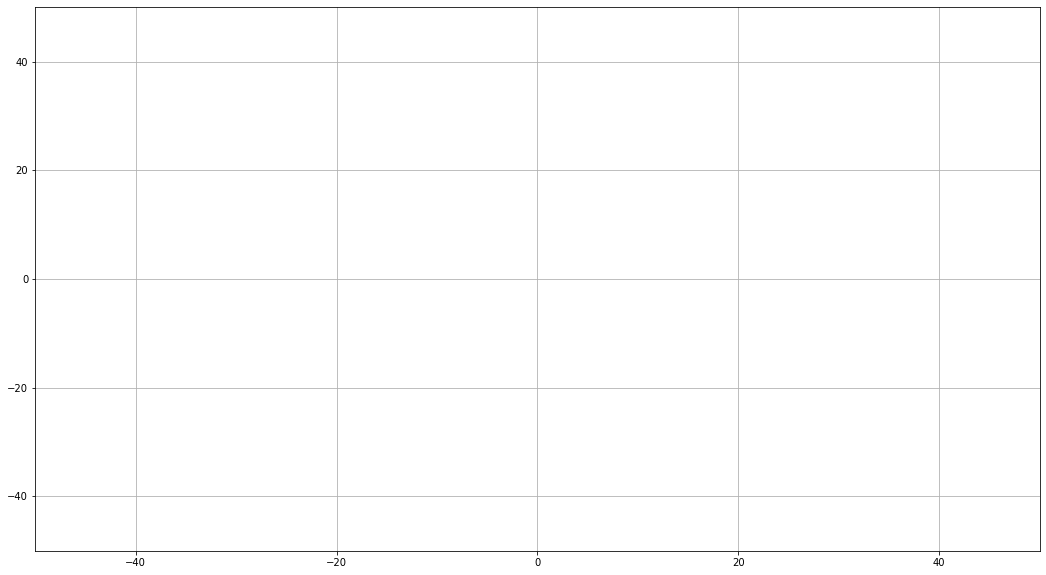

In [7]:
trainer.train()

In [ ]:
import imageio

with imageio.get_writer('information_bottleneck.gif', mode='I', duration = 0.3) as writer:
    for fname in trainer.gifs_list:
        image = imageio.imread(fname)
        writer.append_data(image)

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display
from pathlib import Path

In [ ]:
gifPath = Path("/content/information_bottleneck.gif") 
with open(gifPath,'rb') as f:
    display.Image(data=f.read(), format='png')